<h1>Implement simple NN architecture for regression below:</h1>

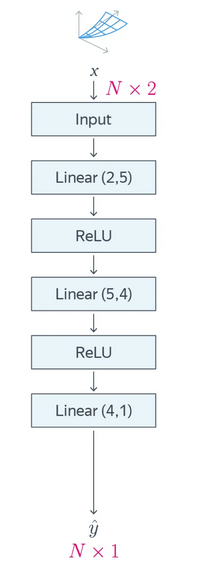

<h1>Load libraries</h1>

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import torch.nn as nn

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

<h1>Create our dataset class</h1>

In [3]:
class DiamondsDataset(Dataset):
    def __init__(self, data, target='target', transform=None):

        if isinstance(data, pd.DataFrame):
            self.data = data
        else:
            raise ValueError
        
        if target in self.data:
            self.target = self.data[target]
            self.data.drop([target], axis=1, inplace=True)
        else:
            raise ValueError

        self.len = self.data.shape[0]
        self.transform = v2.Compose(transform) if transform else None
        self.data = self.transform(self.data) if self.transform else self.data
        self.data = torch.tensor(self.data.to_numpy(), dtype=torch.float)
        self.target = torch.tensor(self.target.to_numpy(), dtype=torch.float)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.data[index], self.target[index]

<h1>Create our own transform</h1>

In [4]:
class Normalise(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, data):
        return (data - self.mean) / self.std

<h1>Write simple NN</h1>

In [5]:
class DiamondsNN(nn.Module):
    def __init__(self, input, hidden_1, hidden_2):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, 1)
        )

    def forward(self, x):
        return self.nn(x)

<h1>Combine all together and train our model</h1>

In [6]:
data = pd.read_csv('diamonds.csv')

enc = OneHotEncoder()
values = enc.fit_transform(
                        data[data.select_dtypes('object').columns]
                            ).toarray()
features = enc.get_feature_names_out()
coded_data = pd.concat(
                        [
                            data.select_dtypes(exclude='object').drop(['Unnamed: 0'], axis=1),
                            pd.DataFrame(values, columns=features)
                        ], axis=1)

coded_data.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
dataset = DiamondsDataset(coded_data, target='price')#, transform=[Normalise(coded_data.mean().mean(), coded_data.std().std())])

In [8]:
model = DiamondsNN(26, 13, 3)

In [9]:
train_data, val_data = random_split(dataset, [0.7, 0.3])

train_loader = DataLoader(train_data, 16, shuffle=True)
val_loader = DataLoader(val_data, 16, shuffle=False)

In [10]:
model_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
EPOCHS = 30
train_loss = []
val_loss = []

for epoch in range(EPOCHS):

    model.train()
    running_train_loss = []
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        pred = model(x)
        loss = model_loss(pred, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        
        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}')

    train_loss.append(mean_train_loss)

    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for x, targets in val_loader:
            pred = model(x)
            loss = model_loss(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

        val_loss.append(mean_val_loss)
        print(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}')

Epoch [1/30], train_loss = 31302538.2873


Epoch [2/30], train_loss = 31284157.0422


Epoch [3/30], train_loss = 31265998.4465


Epoch [4/30], train_loss = 31247632.5153


Epoch [5/30], train_loss = 31230996.5942


Epoch [6/30], train_loss = 31212752.2649


Epoch [7/30], train_loss = 31194674.8743


Epoch [8/30], train_loss = 31175925.5209


Epoch [9/30], train_loss = 31158540.1210


Epoch [10/30], train_loss = 31141757.9167


Epoch [11/30], train_loss = 31122771.2129


Epoch [12/30], train_loss = 31105720.1841


Epoch [13/30], train_loss = 31087613.4930


Epoch [14/30], train_loss = 31069884.4397


Epoch [15/30], train_loss = 31051513.0401


Epoch [16/30], train_loss = 31034196.7573


Epoch [17/30], train_loss = 31016453.1552


Epoch [18/30], train_loss = 30999179.5137


Epoch [19/30], train_loss = 30982014.2596


Epoch [20/30], train_loss = 30963479.1180


Epoch [21/30], train_loss = 30946182.1093


Epoch [22/30], train_loss = 30928959.3268


Epoch [23/30], train_loss = 30910339.1655


Epoch [24/30], train_loss = 30894178.7202


Epoch [25/30], train_loss = 30874465.6386


Epoch [26/30], train_loss = 30858283.1338


Epoch [27/30], train_loss = 30839167.4859


Epoch [28/30], train_loss = 30820989.9558


Epoch [29/30], train_loss = 30803967.5825


Epoch [30/30], train_loss = 30786429.1475


<h1>PLot results</h1>

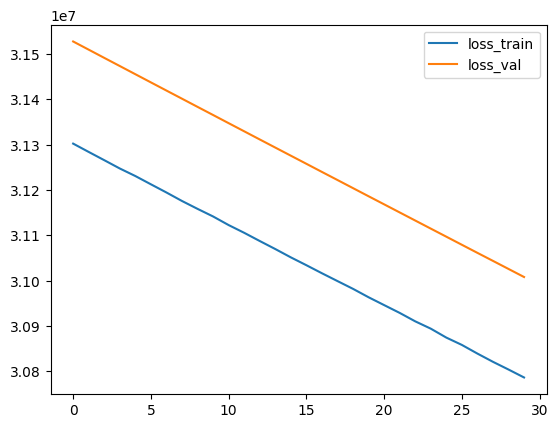

In [13]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()